# ℓ₁-Regularized Least Squares (LASSO) via Proximal Gradient (ISTA)

This notebook presents a small project developed as part of my effort to learn about proximal methods and optimization algorithms.

While studying different regression problems and numerical solvers, I became interested in the following question:

**How does the structure of an objective function influence the optimization method used to solve it?**

Although this is a simple and well-studied question, the specific answer is not the primary focus of this project.  
Instead, the goal is to understand *where* these structural effects emerge within the algorithm and *how* they influence the algorithm’s behavior throughout the optimization process.

Rather than treating optimization methods as black boxes, this notebook connects the mathematical properties of the objective function with the observed computational behavior of the algorithm in practice.

The focus is ℓ₁-regularized linear regression, a problem whose non-smooth geometry fundamentally changes how optimization must be performed and provides a clear setting for studying these effects.

## Why ℓ₁ Regularization?

ℓ₁-regularized regression provides one of the simplest examples of an optimization problem where standard smooth methods are no longer directly applicable.

For comparison, consider the two common regularized least-squares formulations.

The ℓ₂-regularized (ridge) problem is:

$$
\min_x \; \frac12\|Ax - b\|_2^2 + \lambda \|x\|_2^2
$$

This objective is fully smooth and can be efficiently minimized using classical methods such as **gradient descent**, **Newton’s method**, or **conjugate gradient methods**, all of which rely on differentiability of the objective.

In contrast, the ℓ₁-regularized (LASSO) problem is:

$$
\min_x \; \frac12\|Ax - b\|_2^2 + \lambda \|x\|_1
$$

While the least-squares term remains smooth, the ℓ₁ regularization term introduces a non-smooth component. In particular, the ℓ₁ norm is **non-differentiable at zero**, which creates sharp kinks in the geometry of the objective.

Because of this non-smoothness, standard gradient-based methods are no longer well-defined at points where coefficients approach zero, and Newton-type methods that rely on second-order smoothness also break down.

I chose ℓ₁ regularization rather than ℓ₂ because it represents the simplest modification of a smooth regression problem that introduces a fundamental algorithmic complication. The presence of the non-differentiable ℓ₁ term changes not only the solution but also the class of optimization methods that can be applied.

Thus, ℓ₁-regularized regression provides a clean and controlled setting for studying how the structure of an objective function, specifically non-smoothness and sparsity, forces changes in optimization algorithm design.


## Problem Formulation

The problem studied in this project is ℓ₁-regularized least squares:

$$
\min_x \; \frac12\|Ax - b\|_2^2 + \lambda \|x\|_1
$$

where:

- $A \in \mathbb{R}^{m \times n}$ is the design matrix 
- $b \in \mathbb{R}^m$ is the observation vector 
- $x \in \mathbb{R}^n$ is the parameter vector 
- $\lambda > 0$ controls the tradeoff between data fidelity and sparsity

The objective consists of two components:

• a quadratic least-squares term that measures how well the model fits the data  
• an ℓ₁ penalty that encourages sparsity in the coefficients  

The regularization parameter $\lambda$ determines how strongly sparsity is enforced relative to data fidelity.

The least-squares term is smooth and has a Lipschitz-continuous gradient, so from an optimization perspective it behaves well. The ℓ₁ term, however, is fundamentally different: it penalizes all nonzero coefficients uniformly and is non-differentiable at zero.

The factor of one-half in the quadratic term is included for convenience, as it simplifies the gradient without affecting the solution.

Although the full objective is convex, so existence and uniqueness are not the primary concerns, the real challenge arises from combining a smooth term with a non-smooth one. This composite structure creates a geometry that standard gradient-based methods are not designed to handle.

As a result, the central question becomes not simply what the objective is, but how to optimize it in a way that respects this structure, using gradient information where it applies while explicitly handling the non-smooth behavior introduced by the ℓ₁ penalty.


## From Objective Structure to Algorithmic Behavior: ISTA

The composite structure of the ℓ₁-regularized objective fundamentally changes how the problem must be optimized. Standard gradient descent is no longer appropriate because near zero the objective is not smooth, and gradient information alone does not provide a meaningful descent direction.

This places the problem in the class of composite objectives, consisting of a smooth loss function combined with a non-smooth regularizer. For problems of this form, proximal gradient methods provide a natural optimization framework.

Rather than smoothing or approximating the ℓ₁ term, proximal gradient methods handle it directly by pairing a gradient step on the smooth component with a proximal step for the non-smooth component.

For ℓ₁-regularized least squares, this leads to the Iterative Soft-Thresholding Algorithm (ISTA), which performs the update:

$$
x^{k+1} = \mathrm{soft}\left(x^k - \alpha A^\top(Ax^k - b), \alpha \lambda\right)
$$

where the step size is chosen as:

$$
\alpha = \frac{1}{L}, \quad L = \|A\|_2^2
$$

For the ℓ₁ norm, the proximal operator has a closed-form solution given by soft-thresholding:

$$
\mathrm{soft}(z,\alpha\lambda)_i
= \mathrm{sign}(z_i)\max\left(|z_i| - \alpha\lambda,\, 0\right)
$$

This single update directly reflects the composite structure of the objective.

The gradient step reduces the data-fitting error, while the soft-thresholding step explicitly enforces sparsity by shrinking coefficients toward zero and setting small values exactly to zero.

I chose to implement ISTA directly, rather than relying on existing solvers, in order to observe how the mechanics of the algorithm reflect the geometry introduced by the ℓ₁ penalty.

What is most interesting is not simply the algorithm itself, but the behavior it produces. Sparsity is enforced at every iteration, and in practice the iterates tend to identify the active set early in the optimization process. After this point, convergence effectively occurs in a much lower-dimensional subspace.

This update rule drives all of the phenomena observed in the results that follow.

# Implementations
I started by importing the libraries needed for this investigation:

In [48]:
import numpy as np
import matplotlib.pyplot as plt

## Synthetic Data Generation

To study the behavior of ISTA in a controlled setting, I construct a synthetic sparse regression problem with known ground truth.

The design matrix $$A \in \mathbb{R}^{m \times n}$$ is generated with independent Gaussian entries. A sparse true coefficient vector $x^*$ is then constructed by selecting $k$ random indices and assigning them nonzero values drawn from a Gaussian distribution, while all remaining entries are set to zero.

Observations are generated according to the linear model:

$$
b = Ax^* + \varepsilon
$$

where $\varepsilon$ is small Gaussian noise with standard deviation specified by `noise_std`.

This setup provides a simple yet diagnostic test problem. Because the true sparse solution is known, it allows direct examination of:

• how sparsity emerges during optimization  
• whether the correct support is identified  
• how recovery accuracy depends on the regularization parameter  

The goal is not realism, but clarity in observing the effects of ℓ₁ regularization and the behavior of the ISTA algorithm.

In [49]:
def make_synthetic_data(m=120, n=300, k=15, noise_std=0.01, seed=0):

    rng = np.random.default_rng(seed)

    A = rng.normal(size=(m, n))

    x_true = np.zeros(n)
    idx = rng.choice(n, size=k, replace=False)
    x_true[idx] = rng.normal(loc=0.0, scale=1.0, size=k)

    noise = noise_std * rng.normal(size=m)
    b = A @ x_true + noise  # b = Ax* + noise

    return A, b, x_true

### Design walkthrough and Design Choices

- `rng = np.random.default_rng(seed)`  
  Uses NumPy’s modern random generator so results are reproducible via `seed`, the initial state of zero.

- `A = rng.normal(size=(m, n))`  
  Creates a Gaussian design matrix A. This is a standard synthetic setting because it avoids structure that could hide the effect of ℓ₁ regularization.

- `x_true = np.zeros(n)`
  Initializes a coefficient vector of length `n` so sparsity is explicit.

- `idx = rng.choice(n, size=k, replace=False)`  
  RSelects exactly `k` random active coordinates without replacement. This fixes the sparsity level and makes support recovery measurable.

- `x_true[idx] = rng.normal(loc=0.0, scale=1.0, size=k)`  
  Assigns nonzero coefficients with moderate magnitude. Gaussian values make the signal neither too uniform nor adversarial.

- `noise = noise_std * rng.normal(size=m)`  
  Adds small Gaussian noise, controlled by `noise_std`, to avoid a perfectly noiseless case.

- `b = A @ x_true + noise`  
  Generates observations from the linear model $b = Ax^* + \varepsilon$.

- `return A, b, x_true`  
  Returns everything needed for optimization and evaluation: the data, the observations, and the ground truth.


## Objective, Gradient, Prox Operator, and Step Size

Before implementing ISTA, we define the core components required for each iteration of the proximal gradient method.

This includes:

- the **LASSO objective function**, which allows us to track convergence of the full composite objective  
- the **gradient of the smooth least-squares term**, which determines the descent direction that reduces data-fitting error  
- the **soft-thresholding operator**, which is the proximal operator associated with the ℓ₁ norm and explicitly handles the non-smooth regularization term  
- the **step size** $\alpha = \frac{1}{L}$, chosen using the Lipschitz constant of the gradient of the smooth loss  

The soft-thresholding operator arises from solving the proximal subproblem associated with the ℓ₁ penalty. At each iteration, instead of directly minimizing the full objective, proximal gradient methods minimize a local quadratic approximation of the smooth loss combined with the ℓ₁ regularizer. For the ℓ₁ norm, this minimization has a closed-form solution given by soft-thresholding.

Intuitively, soft-thresholding performs two actions simultaneously:

- it **shrinks** large coefficients toward zero  
- it **eliminates** small coefficients entirely by setting them exactly to zero  

This is the mechanism through which sparsity is enforced during optimization.

The step size $\alpha$ is determined by the Lipschitz constant $L$ of the gradient of the smooth term $f(x)=\tfrac12\|Ax-b\|_2^2$.  
For least squares, this constant is:

$$
L = \|A\|_2^2
$$

where $\|A\|_2$ denotes the spectral norm (largest singular value) of $A$.

This quantity measures how rapidly the gradient of the loss can change. Choosing $\alpha = \frac{1}{L}$ ensures that each proximal gradient step is stable and that the composite objective decreases monotonically under standard theoretical conditions.

Together, these components translate the mathematical structure of the objective directly into the mechanics of the ISTA update used in the following section.


In [50]:
def lasso_objective(A, b, x, lam):
    r = A @ x - b
    return 0.5 * (r @ r) + lam * np.linalg.norm(x, 1)

def grad_least_squares(A, b, x):
    return A.T @ (A @ x - b)

def soft_threshold(z, t):
    return np.sign(z) * np.maximum(np.abs(z) - t, 0.0)

def lipschitz_step(A):
    smax = np.linalg.norm(A, 2)
    L = smax * smax
    return 1.0 / L



### Walkthrough and Design Choices

**`lasso_objective(A, b, x, lam)`**
- Computes $\tfrac12\|Ax - b\|_2^2$. The factor $\tfrac12$ simplifies derivatives and does not change the minimizer.

- `lam * np.linalg.norm(x, 1)`  
  Adds the ℓ₁ penalty $\lambda\|x\|_1$, which encourages sparsity by penalizing all nonzero coefficients.


**`grad_least_squares(A, b, x)`**

- Computes the gradient of the smooth term denonted as:

  $$
  \nabla\left(\tfrac12\|Ax - b\|_2^2\right) = A^\top(Ax - b)
  $$

  This provides the descent direction used in the gradient step of ISTA.


**`soft_threshold(z, t)`**

- `np.sign(z)`  
  Preserves the sign of each coordinate.

- `np.maximum(np.abs(z) - t, 0.0)`  
  Shrinks each magnitude by $t$ and sets values that fall below zero exactly to zero.

- Overall effect  
  Implements coordinate-wise soft-thresholding:

  $$
  \mathrm{soft}(z, t)_i = \mathrm{sign}(z_i)\max(|z_i| - t, 0)
  $$

  This is the proximal operator for the ℓ₁ norm and is responsible for enforcing sparsity during optimization.


**`lipschitz_step(A)`**

- `smax = np.linalg.norm(A, 2)`  
  Computes $\|A\|_2$, or the largest singular value of $A$, which measures the maximum amount by which $A$ can stretch a vector, and squaring this value yields the Lipschitz constant required to select a stable ISTA step size.

- `return 1.0 / L`  
  Chooses the step size $\alpha = \frac{1}{L}$, a standard choice in proximal gradient methods that ensures stable updates and monotone decrease of the objective in this setting.


## ISTA Implementation and Instrumentation

This function implements the Iterative Soft-Thresholding Algorithm (ISTA) to solve the ℓ₁-regularized least-squares problem.

The algorithm proceeds by repeatedly applying:

- a gradient step on the smooth least-squares loss  
- followed by a soft-thresholding step that enforces sparsity  

In addition to computing the iterates, the implementation is instrumented to record:

- the value of the full LASSO objective at each iteration  
- the number of nonzero coefficients in the solution  

Tracking both quantities allows analysis not only of convergence, but also of how sparsity and active-set identification evolve throughout optimization.

The stopping criterion is based on the relative change between successive iterates, ensuring termination once updates become sufficiently small.

In [51]:
def ista(A, b, lam, max_iter=500, tol=1e-6):

    n = A.shape[1]
    x = np.zeros(n)
    step = lipschitz_step(A)

    history = {"obj": [], "nnz": []}

    for it in range(max_iter):

        g = grad_least_squares(A, b, x)
        x_next = soft_threshold(x - step * g, step * lam)

        obj = lasso_objective(A, b, x_next, lam)
        history["obj"].append(obj)
        history["nnz"].append(int(np.count_nonzero(x_next)))

        if np.linalg.norm(x_next - x) <= tol * max(1.0, np.linalg.norm(x)):
            x = x_next
            break

        x = x_next

    return x, history


### Walkthrough and Design Choices

**Initialization**

- `n = A.shape[1]`  
  Sets the dimension of the coefficient vector to match the number of features.

- `step = lipschitz_step(A)`  
  Computes the step size  
  $$
  \alpha = \frac{1}{L}, \quad L = \|A\|_2^2
  $$  
  ensuring stability of the proximal gradient updates.

**History tracking**

- `history = {"obj": [], "nnz": []}`  
  Creates containers to record:

  • the LASSO objective value at each iteration  
  • the number of nonzero coefficients  

  This allows simultaneous study of convergence and sparsity evolution.

**Main ISTA loop**

- `g = grad_least_squares(A, b, x)`  
  Computes the gradient of the smooth loss:

  $$
  \nabla f(x) = A^\top(Ax - b)
  $$

- `x_next = soft_threshold(x - step * g, step * lam)`  
  Performs the ISTA update:

  $$
  x^{k+1} = \mathrm{soft}\left(x^k - \alpha \nabla f(x^k), \alpha \lambda\right)
  $$

  The gradient step reduces data-fitting error, and the soft-thresholding step enforces sparsity.


**Diagnostics**

- `obj = lasso_objective(A, b, x_next, lam)`  
  Evaluates the full composite objective  
  $$
  \tfrac12\|Ax-b\|_2^2 + \lambda\|x\|_1
  $$

- `history["obj"].append(obj)`  
  Stores objective value for convergence analysis.

- `history["nnz"].append(int(np.count_nonzero(x_next)))`  
  Records the number of nonzero coefficients to track sparsity over time.


**Stopping condition**

- `np.linalg.norm(x_next - x) <= tol * max(1.0, np.linalg.norm(x))`  

  Terminates when the relative change between iterates becomes sufficiently small, indicating practical convergence.

**Update and return**

- `x = x_next`  
  Advances to the next iterate.

- `return x, history`  
  Returns the final solution along with recorded diagnostics for analysis and plotting.


## Main Function - Running ISTA and Visualizing Behavior

This section runs ISTA on a single synthetic LASSO instance and then visualizes the optimization dynamics.

The workflow is:

1. Generate a controlled synthetic problem $(A, b, x^*)$ with known sparse ground truth.  
2. Choose a representative regularization value $\lambda = 0.05$ and run ISTA to obtain an estimate $\hat{x}$.  
3. Print summary diagnostics, including sparsity of $\hat{x}$, the final objective value, and recovery error $\|\hat{x} - x^*\|_2$.  
4. Plot three diagnostics for a single run:
   - objective value vs iteration  
   - number of nonzeros vs iteration  
   - true vs recovered coefficients  
5. Perform a sweep over $\lambda$ to study how the regularization parameter controls:
   - final sparsity  
   - recovery error  

These plots are intended to highlight the qualitative behavior discussed earlier, particularly active-set identification and the bias–sparsity tradeoff.


Recovered nonzeros: 235
Final objective: 1.1901585916932367
L2 error ||x_hat - x_true||: 2.7684570543592613


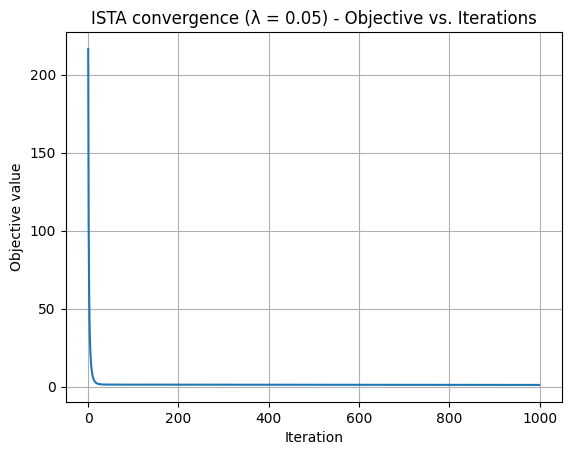

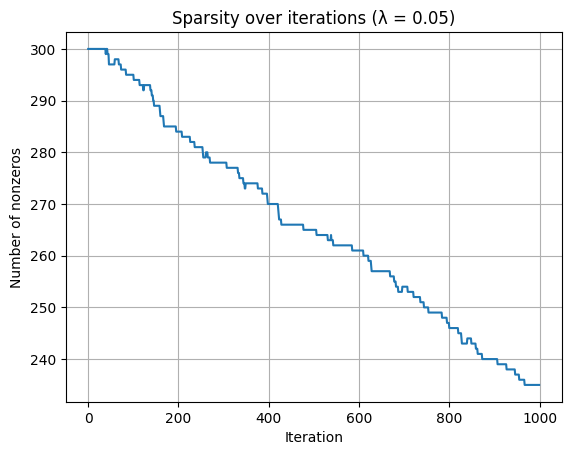

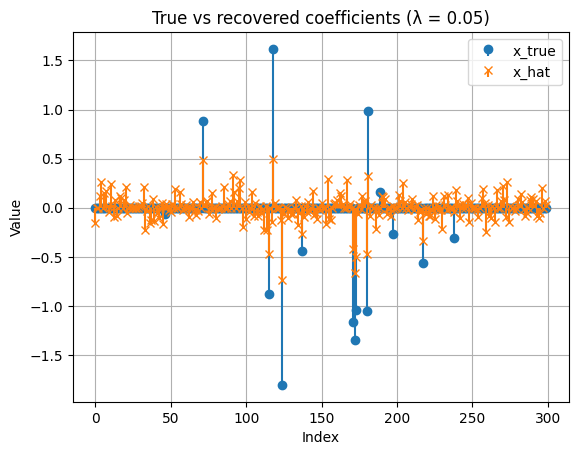

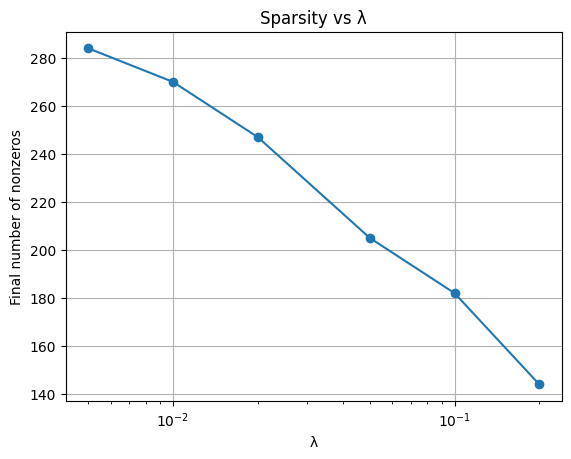

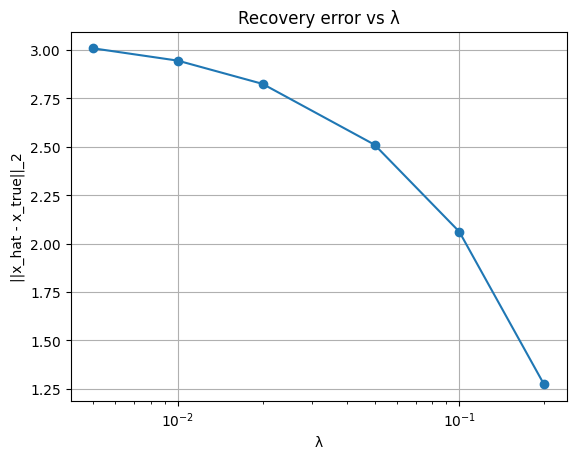

In [52]:
if __name__ == "__main__":
    A, b, x_true = make_synthetic_data(m=120, n=300, k=15, noise_std=0.01, seed=0)

    lam = 0.05
    x_hat, hist = ista(A, b, lam, max_iter=1000)

    print("Recovered nonzeros:", np.count_nonzero(x_hat))
    print("Final objective:", hist["obj"][-1])
    print("L2 error ||x_hat - x_true||:", np.linalg.norm(x_hat - x_true))

    # ---- Plot 1: Objective value ----
    plt.figure()
    plt.plot(hist["obj"])
    plt.xlabel("Iteration")
    plt.ylabel("Objective value")
    plt.title(f"ISTA convergence (λ = {lam}) - Objective vs. Iterations")
    plt.grid(True)
    plt.show()


    # ---- Plot 2: Nonzero count ----
    plt.figure()
    plt.plot(hist["nnz"])
    plt.xlabel("Iteration")
    plt.ylabel("Number of nonzeros")
    plt.title(f"Sparsity over iterations (λ = {lam})")
    plt.grid(True)
    plt.show()

    # ---- Plot 3: Support comparison (x_true vs x_hat) ----
    plt.figure()
    plt.stem(x_true, linefmt='C0-', markerfmt='C0o', basefmt=" ", label='x_true')
    plt.stem(x_hat,  linefmt='C1-', markerfmt='C1x', basefmt=" ", label='x_hat')
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.title(f"True vs recovered coefficients (λ = {lam})")
    plt.legend()
    plt.grid(True)
    plt.show()


    # ---- Plot 4: lambda sweep ----
    lams = [0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
    final_nnz = []
    final_err = []

    for lam_i in lams:
        x_hat_i, hist_i = ista(A, b, lam_i, max_iter=2000)
        final_nnz.append(np.count_nonzero(x_hat_i))
        final_err.append(np.linalg.norm(x_hat_i - x_true))

    plt.figure()
    plt.plot(lams, final_nnz, marker='o')
    plt.xscale("log")
    plt.xlabel("λ")
    plt.ylabel("Final number of nonzeros")
    plt.title("Sparsity vs λ")
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(lams, final_err, marker='o')
    plt.xscale("log")
    plt.xlabel("λ")
    plt.ylabel("||x_hat - x_true||_2")
    plt.title("Recovery error vs λ")
    plt.grid(True)
    plt.show()